In [1]:
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import numpy as np
import torch
import sys
import os

from emle.models import EMLE
from emle.train._utils import pad_to_max
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, kendalltau

script_dir = os.path.dirname(os.getcwd()) 
parent_dir = os.path.join(script_dir)
sys.path.append(parent_dir)  

from utils import compute_metrics

/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [2]:
# Set the path to the models
models_dict = {
    "QM7-Species": "../../emle_models/emle_qm7_aev.mat",
    "Bespoke-Iter2-Species": "/scratch1/joao/tip3p_final/bespoke_models/test/training_iter2/ligand_bespoke.mat",
    "Patched-Iter2-Species": "../../emle_models/ligand_patched_species_iter2.mat"
}

In [3]:
# Load the testing data 
testing_data_paths = [
    "../../data/testing_training_data/merged_testing_data_iter_1.pkl",
    "../../data/testing_training_data/merged_ref_data_iter_2.pkl",
    "../../data/testing_training_data/merged_testing_data_iter_3.pkl",
]

# Initialize lists to store data
xyz_qm, xyz_mm, z, charges_mm = [], [], [], []
e_static_ref, e_ind_ref, s, mu, q_core, q_val, alpha = [], [], [], [], [], [], []

# Load and aggregate data from each file
for data_path in testing_data_paths:
    data = pkl.load(open(data_path, "rb"))
    xyz_qm.extend(data["xyz_qm"])
    xyz_mm.extend(data["xyz_mm"])
    z.extend(data["z"])
    charges_mm.extend(data["charges_mm"])
    e_static_ref.extend(data["e_static"])
    e_ind_ref.extend(data["e_ind"])
    s.extend(data["s"])
    mu.extend(data["mu"])
    q_core.extend(data["q_core"])
    q_val.extend(data["q_val"])
    alpha.extend(data["alpha"])

# Pad to max and convert to torch tensors
xyz_qm = pad_to_max(xyz_qm)
xyz_mm = pad_to_max(xyz_mm)
z = pad_to_max(z)
charges_mm = pad_to_max(charges_mm)
e_static_ref = torch.tensor(e_static_ref)
e_ind_ref = torch.tensor(e_ind_ref)
s_ref = pad_to_max(s)
mu_ref = pad_to_max(mu)
q_core_ref = pad_to_max(q_core)
q_val_ref = pad_to_max(q_val)
alpha_ref = pad_to_max(alpha)

In [4]:
alpha_ref.shape

torch.Size([6000, 3, 3])

In [5]:
# Evaluate the EMLE energy for each model
emle_mbis_dict = {}

for model_name, model_path in models_dict.items():
    emle_model = EMLE(model=model_path, alpha_mode="species").double()
    emle_base = emle_model._emle_base

    s, q_core, q_val, A_thole = emle_base.forward(
        z,
        xyz_qm,
        torch.zeros(len(xyz_qm))
    )
    
    # Calculate molecular polarizability
    mask = z > 0
    n_atoms = mask.shape[1]
    mask_mat = (
        (mask[:, :, None] * mask[:, None, :])
        .repeat_interleave(3, dim=1)
        .repeat_interleave(3, dim=2)
    )

    A_thole_inv = torch.where(mask_mat, torch.linalg.inv(A_thole), 0.0)
    pol = torch.sum(A_thole_inv.reshape((-1, n_atoms, 3, n_atoms, 3)), dim=(1, 3)).detach().numpy()

    emle_mbis_dict[model_name] = {
        "s": s.detach().numpy(),
        "q_core": q_core.detach().numpy(),
        "q_val": q_val.detach().numpy(),
        "pol": pol
    }


with open("emle_mbis_qm_dict.pkl", "wb") as f:
    pkl.dump(emle_mbis_dict, f)

<Axes: ylabel='Density'>

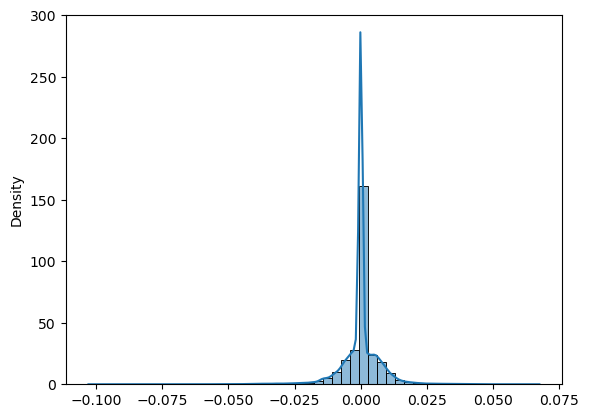

In [6]:
x=emle_mbis_dict['Bespoke-Iter2-Species']['q_val']-emle_mbis_dict['Patched-Iter2-Species']['q_val']
x.flatten()
sns.histplot(x.flatten(), bins=50, kde=True, stat='density')

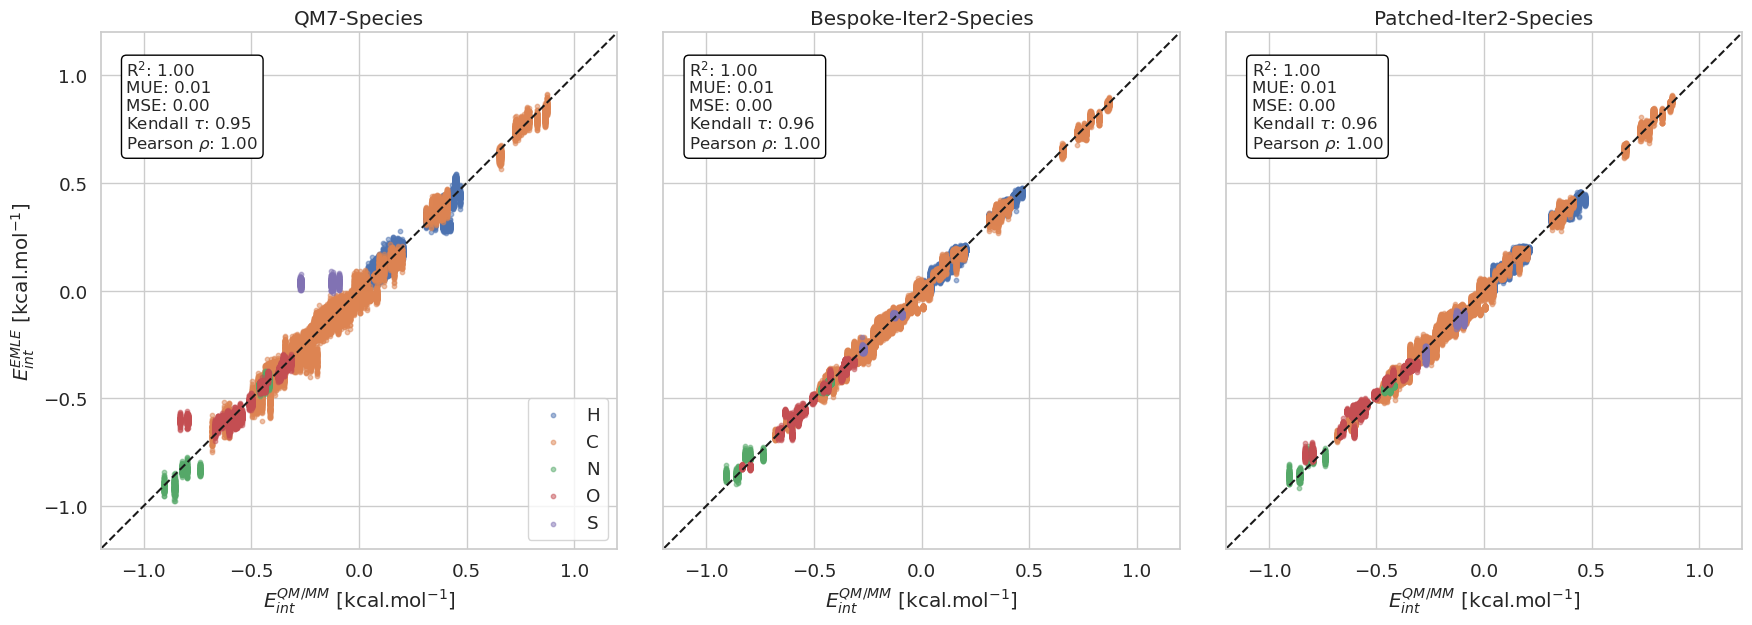

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True) 

x = np.linspace(-1000, 1000, 100)
y = x

xlims = (0.3, 0.65)
ylims = (0.3, 0.65)

xlims = (-1.2, 1.2)
ylims = (-1.2, 1.2)

z_flatten = np.array(z).flatten()

atomic_masks = {
    "H": z_flatten == 1,
    "C": z_flatten == 6,
    "N": z_flatten == 7,
    "O": z_flatten == 8,
    "S": z_flatten == 16,
}

for i, (model_name, mbis) in enumerate(emle_mbis_dict.items()):
    axes[i].set_aspect("equal")
    axes[i].set_xlim(*xlims)
    axes[i].set_ylim(*ylims)
    axes[i].plot(x, y, "k--")

    predicted = mbis["q_val"].flatten()
    reference = q_val_ref.detach().flatten().numpy()

    mue, mse, kendall, pearson, r2, rmse = compute_metrics(reference, predicted)
    
    for atom, mask in atomic_masks.items():
        predicted = mbis["q_val"].flatten() + mbis["q_core"].flatten()
        reference = q_val_ref.detach().flatten() + q_core_ref.flatten()
        predicted = predicted[mask]
        reference = reference[mask]
        axes[i].scatter(reference, predicted, label=atom, alpha=0.5, s=10)

    axes[i].set_xlabel("$E^{QM/MM}_{int}$ [kcal.mol$^{-1}]$")
    #axes[i].set_ylabel("$E^{EMLE}$ [kcal.mol$^{-1}]$")
    axes[i].set_title(f"{model_name}")

    # Display RMSE, MSE, R^2 on the Static plot
    axes[i].text(
        0.05,
        0.95,
        f"R$^2$: {r2:.2f}\nMUE: {mue:.2f}\nMSE: {mse:.2f}\nKendall $\\tau$: {kendall:.2f}\nPearson $\\rho$: {pearson:.2f}",
        transform=axes[i].transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
    )


axes[0].legend()
axes[0].set_ylabel("$E^{EMLE}_{int}$ [kcal.mol$^{-1}]$")

plt.tight_layout()
plt.savefig("emle_models_perf.pdf", dpi=300, bbox_inches="tight")

plt.show()


In [8]:
x = emle_mbis_dict["Patched-Iter2-Species"]["q_val"].flatten()
r = q_val_ref.detach().flatten().numpy()


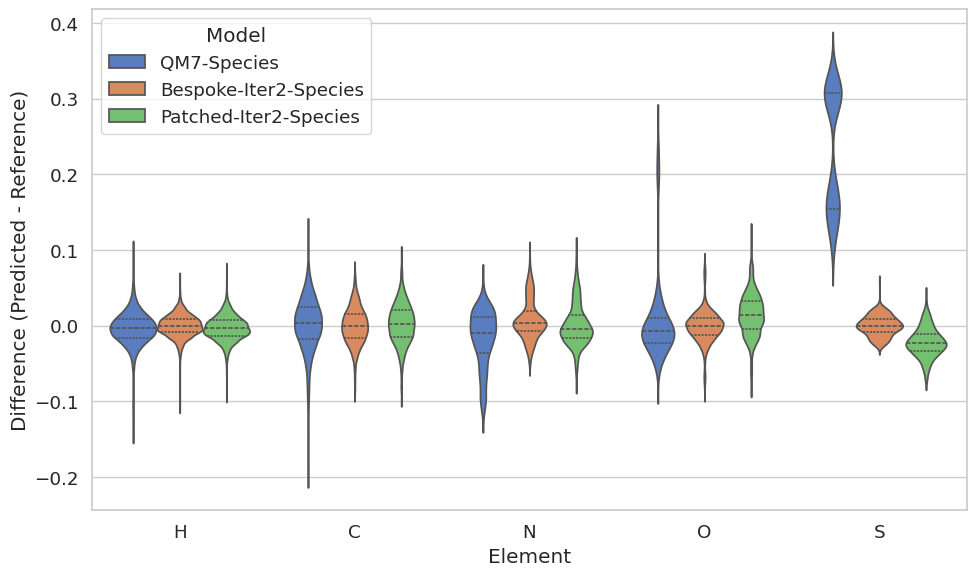

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Set style for the plot
sns.set(style="whitegrid", font_scale=1.2)

# Prepare the data for the plot
data = []

xlims = (-1.2, 1.2)
ylims = (-1.2, 1.2)

# Prepare data for each model
for i, (model_name, mbis) in enumerate(emle_mbis_dict.items()):
    predicted = mbis["q_val"].flatten() + mbis["q_core"].flatten()
    reference = q_val_ref.detach().flatten() + q_core_ref.flatten()

    # Calculate the difference between predicted and reference values
    diff = predicted - reference.numpy()

    # Loop over atomic masks and prepare data grouped by element
    for atom, mask in atomic_masks.items():
        atom_diff = diff[mask]
        
        # Add data for violin plot (model, atom, difference)
        for value in atom_diff:
            data.append({"Model": model_name, "Atom": atom, "Difference": value})

# Convert data to a DataFrame for easier manipulation with Seaborn
df = pd.DataFrame(data)

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Atom", y="Difference", hue="Model", data=df, split=False, inner="quart", palette="muted")

# Adding titles and labels
plt.xlabel("Element")
plt.ylabel("Difference (Predicted - Reference)")

# Show the plot
plt.tight_layout()
#plt.savefig("violin_plot_diff_models.pdf", dpi=300, bbox_inches="tight")
plt.show()


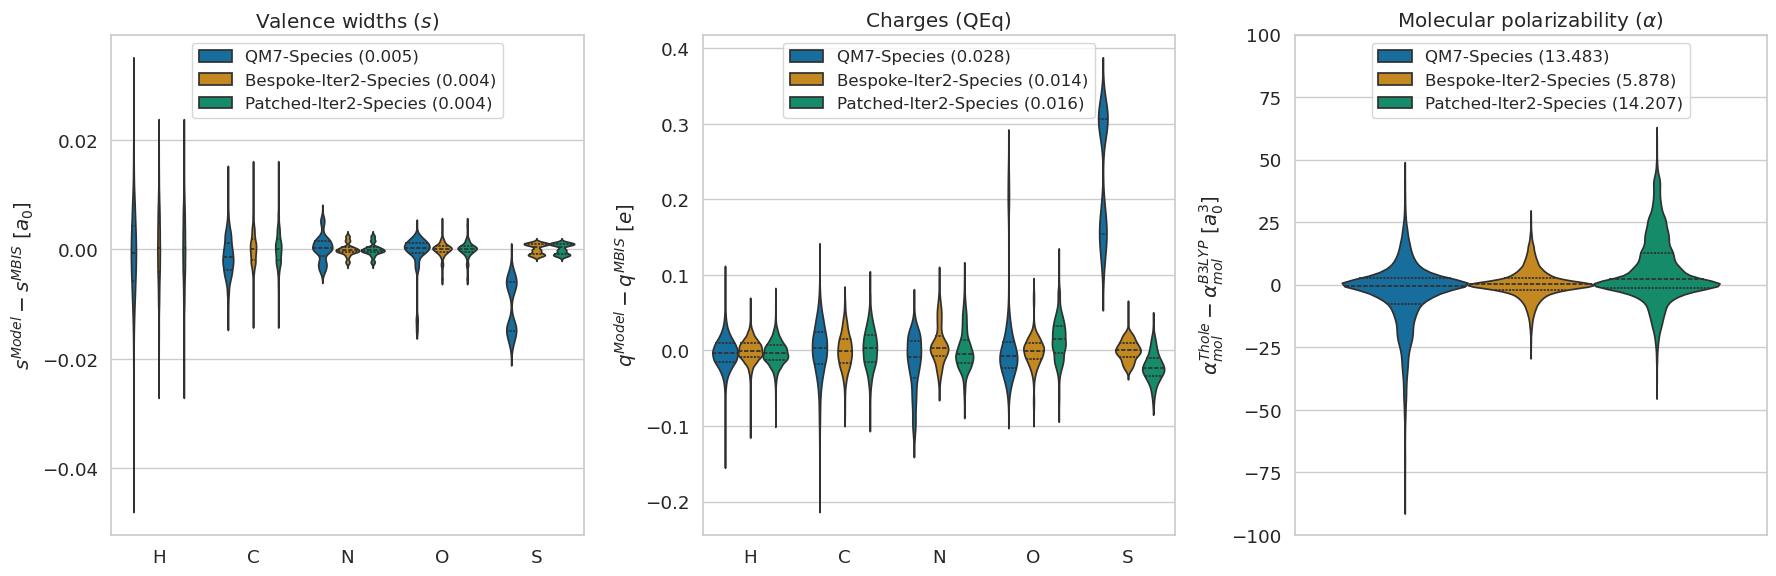

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error

sns.set(style="whitegrid", font_scale=1.2)

def calculate_rmse(predicted, reference):
    return np.sqrt(mean_squared_error(reference, predicted))

data = []
rmse_values = {}

for i, (model_name, mbis) in enumerate(emle_mbis_dict.items()):
    s_predicted = mbis["s"].flatten()
    s_reference = s_ref.detach().flatten().numpy()

    s_rmse = calculate_rmse(s_predicted, s_reference)
    rmse_values[model_name] = {"S": s_rmse}

    s_diff = s_predicted - s_reference

    for atom, mask in atomic_masks.items():
        atom_s_diff = s_diff[mask]
        for value in atom_s_diff:
            data.append({"Model": model_name, "Atom": atom, "Difference": value, "Type": "S vs Sref"})

    predicted = mbis["q_val"].flatten() + mbis["q_core"].flatten()
    reference = q_val_ref.detach().flatten() + q_core_ref.flatten()

    charge_rmse = calculate_rmse(predicted, reference)
    rmse_values[model_name]["Charge"] = charge_rmse

    charge_diff = predicted - reference.numpy()

    for atom, mask in atomic_masks.items():
        atom_charge_diff = charge_diff[mask]
        for value in atom_charge_diff:
            data.append({"Model": model_name, "Atom": atom, "Difference": value, "Type": "Charges"})

    predicted = mbis["pol"].flatten()
    reference = alpha_ref.flatten().numpy()

    pol_diff = predicted - reference

    pol_rmse = calculate_rmse(predicted, reference)
    rmse_values[model_name]["Polarizability"] = pol_rmse
    
    atom = "All"
    for value in pol_diff:
        data.append({"Model": model_name, "Atom": atom, "Difference": value, "Type": "Polarizability"})

df = pd.DataFrame(data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Atomic Widths
sns.violinplot(x="Atom", y="Difference", hue="Model", data=df[df["Type"] == "S vs Sref"], ax=axes[0], split=False, inner="quart", palette="colorblind")
axes[0].set_title("Valence widths ($s$)")
axes[0].set_ylabel("$s^{Model}-s^{MBIS}$ [$a_0$]")

# Charges
sns.violinplot(x="Atom", y="Difference", hue="Model", data=df[df["Type"] == "Charges"], ax=axes[1], split=False, inner="quart", palette="colorblind")
axes[1].set_title("Charges (QEq)")
axes[1].set_ylabel(r"$q^{Model}-q^{MBIS}$ [$e$]")

# Polarizabilities
sns.violinplot(x="Atom", y="Difference", hue="Model", data=df[df["Type"] == "Polarizability"], ax=axes[2], split=False, inner="quart", palette="colorblind")
axes[2].set_title(r"Molecular polarizability ($\alpha$)")
axes[2].set_ylabel(r"$\alpha^{Thole}_{mol}-\alpha^{B3LYP}_{mol}$ [$a_0^3$]")
axes[2].set_xticklabels([])
axes[2].set_ylim(-100, 100)


for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        model_name = label
      
        if ax == axes[0]:  
            rmse_value = rmse_values.get(model_name, {}).get("S", 0)
            new_label = f"{model_name} ({rmse_value:.3f})"
        elif ax == axes[1]:  
            rmse_value = rmse_values.get(model_name, {}).get("Charge", 0)
            new_label = f"{model_name} ({rmse_value:.3f})"
        elif ax == axes[2]:  
            rmse_value = rmse_values.get(model_name, {}).get("Polarizability", 0)
            new_label = f"{model_name} ({rmse_value:.3f})"
        new_labels.append(new_label)
    ax.legend(handles=handles[0:], labels=new_labels, loc="upper center", fontsize="small")
    """
    if ax == axes[0]:
    else:
        # no legend
        ax.legend_.remove()
    """
    ax.set_xlabel("")

plt.tight_layout()
plt.savefig("violin_plots_with_rmse.pdf", dpi=300, bbox_inches="tight")
plt.show()